<a href="https://colab.research.google.com/github/CrisMcode111/fraude-credit-hackathon/blob/main/fraude_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection and Prevention

## 1. Project Overview
This project explores anonymized credit card transactions to better understand how fraud occurs.  
Fraudulent transactions represent only ~0.17% of all records, which makes them very hard to detect but also very important to monitor.  
Our analysis highlights patterns in amounts, timing, and hidden features that can guide prevention strategies.

---

## 2. Exploratory Data Analysis (EDA)
- We examined the distribution of transactions by class: the dataset is extremely imbalanced.  
- Transaction amounts are mostly small, but fraud tends to cluster in specific ranges.  
- When analyzing time of day, fraudulent activity appears disproportionately at unusual hours (night/early morning).  
- Using correlation analysis, we found that some anonymized variables (e.g., V14, V10, V12) are strongly associated with fraud.  
- Scatter plots confirm that fraudulent transactions form visible clusters in certain feature combinations.  

---

## 3. Data Preprocessing
- No missing values were detected in the dataset.  
- Transaction amounts were log-transformed to better visualize patterns.  
- The class imbalance was highlighted as a major challenge: in practice, techniques like oversampling, undersampling, or SMOTE would be applied before modeling.  

---

## 4. Feature Analysis
- Even though features are anonymized (V1–V28), some carry much stronger signals for fraud.  
- These top predictors can be prioritized in monitoring systems or combined into aggregated risk scores.  
- This helps focus prevention efforts on the most informative parts of the data.  

---

## 5. Predictive Modeling (Next Step)
- While this notebook focused on analysis and visualization, predictive models (e.g., Random Forest or Gradient Boosting) can be used to classify fraud vs. genuine transactions.  
- Evaluation should focus on **catching as many frauds as possible** while **avoiding too many false alarms**.  
- This balance is more important than simple accuracy, given the extreme imbalance of the dataset.  

---

## 6. Visualization Highlights
- Clear visualizations were created with Matplotlib and Seaborn:
  - Class imbalance (0 = genuine, 1 = fraud).  
  - Amount distribution overall and by class.  
  - Fraud by hour of day.  
  - Correlation heatmaps and top features.  
  - Scatter plots showing fraud clusters.  
- These visuals make the problem easy to understand for both technical and business stakeholders.  

---

## 7. Fraud Prevention Strategy
- **Real-time monitoring:** transactions are scored instantly, with alerts for high-risk cases.  
- **Dynamic rules:** special attention to unusual hours, suspicious amount ranges, and rapid repeated transactions.  
- **Step-up authentication:** high-risk transactions require additional confirmation from the customer.  
- **Data enrichment:** incorporating location, device/browser fingerprint, and merchant information would improve accuracy.  
- **Business value:** this approach combines data-driven detection with clear rules, making it practical and trustworthy for financial institutions.  

---

## 8. Dataset
The dataset used is `creditcard.csv` from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).  
It contains anonymized features (V1–V28), transaction `Amount` and `Time`, and the `Class` label (0 = genuine, 1 = fraud).


In [ ]:
%pip install -q pandas numpy scikit-learn imbalanced-learn xgboost lightgbm shap matplotlib seaborn


# EDA — Credit Card Fraud Detection

Goal: Explore the dataset, visualize class imbalance, plot basic distributions and correlations, and build a baseline Logistic Regression (with `class_weight='balanced'`).  
We will evaluate the baseline using Precision–Recall curve and experiment with threshold tuning.


In [27]:
# Core libraries
import sys, platform
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split & scaling (optional, only if you prepare subsets of data)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation metrics (only keep those useful for imbalance context)
from sklearn.metrics import (
    precision_recall_curve, average_precision_score
)

# Reproducibility
np.random.seed(42)

# Check versions (good practice in hackathon notebooks)
print("Python:", platform.python_version())
for p in ["numpy","pandas","scikit-learn","seaborn","matplotlib"]:
    try:
        mod = __import__(p if p!="scikit-learn" else "sklearn")
        print(f"{p}:", mod.__version__ if p!="scikit-learn" else mod.__version__)
    except Exception as e:
        print(p, "not found", e)

# Visualization style
sns.set(style="whitegrid")

# Optional: suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


Python: 3.12.12
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
seaborn: 0.13.2
matplotlib: 3.10.0


In [15]:
# 1. Créer le dossier cible
!mkdir -p /content/credit_card_fraud_detection
!unzip /content/Credit_Card_Fraud_Detection.zip -d /content/credit_card_fraud_detection


Archive:  /content/Credit_Card_Fraud_Detection.zip
   creating: /content/credit_card_fraud_detection/Credit Card Fraud Detection/Credit Card Fraud Detection/
  inflating: /content/credit_card_fraud_detection/Credit Card Fraud Detection/Credit Card Fraud Detection/creditcard.csv  


In [18]:
df = pd.read_csv('/content/credit_card_fraud_detection/Credit Card Fraud Detection/Credit Card Fraud Detection/creditcard.csv')

In [19]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# # Robust loader for Colab: handles .csv OR .zip with a CSV inside
# from google.colab import files
# import io, zipfile, pandas as pd, os

# uploaded = files.upload()  # pick your file (.csv or .zip)

# df = None
# for fname, data in uploaded.items():
#     lname = fname.lower()
#     if lname.endswith(".csv"):
#         df = pd.read_csv(io.BytesIO(data), low_memory=False)
#         print(f"Loaded CSV: {fname}")
#         break
#     elif lname.endswith(".zip"):
#         z = zipfile.ZipFile(io.BytesIO(data))
#         # find a CSV inside the zip (first one)
#         csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
#         if not csvs:
#             raise FileNotFoundError("No CSV found inside the ZIP.")
#         # extract & read
#         target = csvs[0]
#         z.extract(target)              # extracts to current working dir
#         df = pd.read_csv(target, low_memory=False)
#         print(f"Loaded CSV from ZIP: {target}")
#         break

# if df is None:
#     raise RuntimeError("Please upload a .csv or a .zip containing a CSV.")

# print(df.shape)


Saving Credit Card Fraud Detection.zip to Credit Card Fraud Detection.zip
Loaded CSV from ZIP: Credit Card Fraud Detection/Credit Card Fraud Detection/creditcard.csv
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


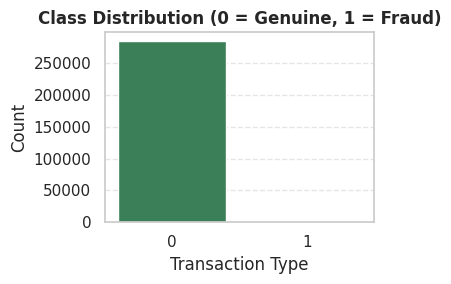

In [28]:
import matplotlib.ticker as mtick

main_color = "seagreen"
accent_color = "darkgreen"

# 5.1 Class distribution
plt.figure(figsize=(4,3))
sns.countplot(x="Class", data=df, palette=[main_color, accent_color])
plt.title("Class Distribution (0 = Genuine, 1 = Fraud)", fontsize=12, weight="bold")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


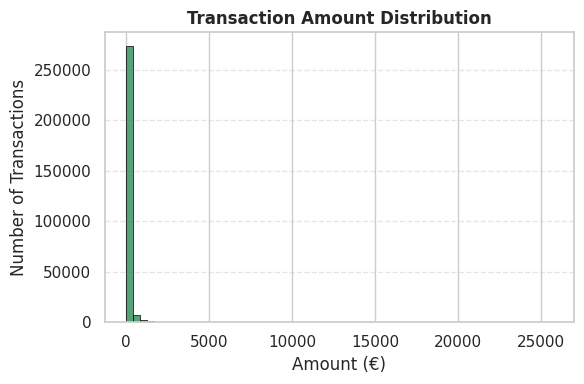

In [29]:

# 5.2 Histogram of Amount
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=60, color=main_color, edgecolor="black", alpha=0.8)
plt.title("Transaction Amount Distribution", fontsize=12, weight="bold")
plt.xlabel("Amount (€)")
plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



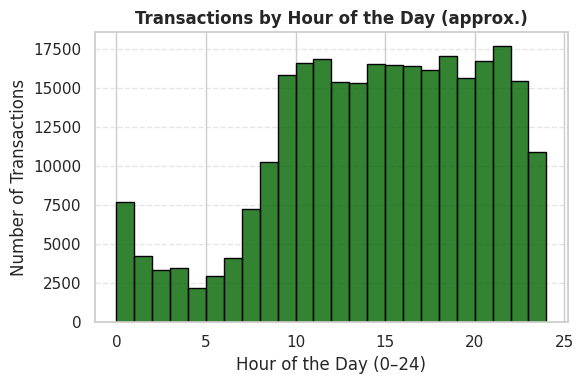

In [30]:

# 5.3 Histogram by approximate hours of day
if 'Time' in df.columns:
    time_hours = (df['Time'] % 86400) / 3600.0
    plt.figure(figsize=(6,4))
    sns.histplot(time_hours, bins=24, color=accent_color, edgecolor="black", alpha=0.8)
    plt.title("Transactions by Hour of the Day (approx.)", fontsize=12, weight="bold")
    plt.xlabel("Hour of the Day (0–24)")
    plt.ylabel("Number of Transactions")
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


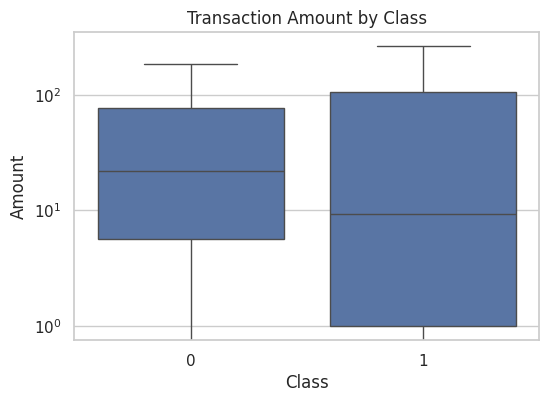

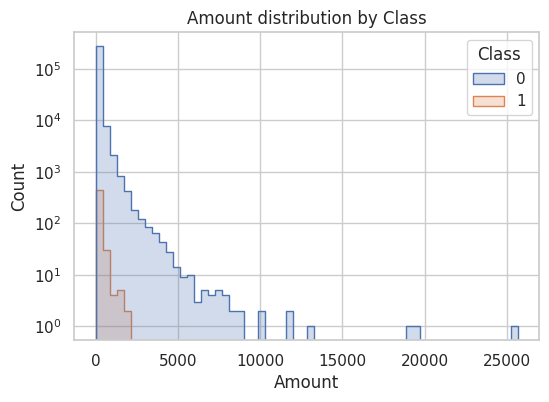

In [ ]:
# Boxplot: Amount by Class
plt.figure(figsize=(6,4))
sns.boxplot(x="Class", y="Amount", data=df, showfliers=False)
plt.yscale("log")
plt.title("Transaction Amount by Class")
plt.show()

# Histogram of Amount by Class
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Amount", hue="Class", bins=60, element="step", common_norm=False)
plt.yscale("log")
plt.title("Amount distribution by Class")
plt.show()


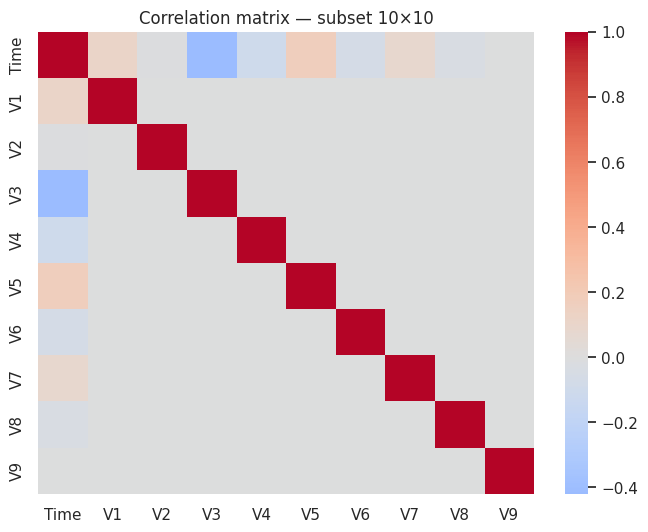

In [34]:
num_cols = [c for c in df.columns if c != 'Class']
corr = df[num_cols + ['Class']].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr.iloc[:10,:10], cmap="coolwarm", center=0)
plt.title("Correlation matrix — subset 10×10")
plt.show()


### Correlation Matrix (subset of variables)

This heatmap shows how variables relate to each other and to the fraud label.  
Some variables are strongly linked, which indicates redundancy, while others show clear connection with fraud.  
This helps us identify which features are worth monitoring more closely.


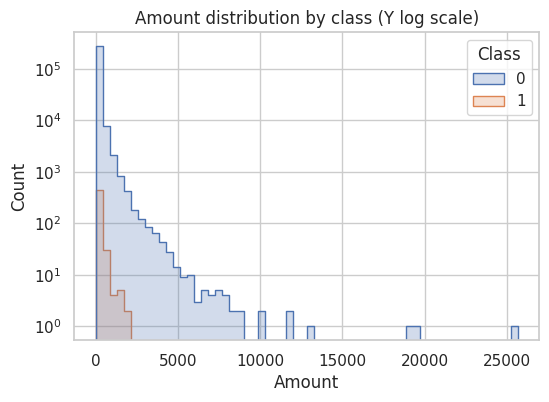

In [35]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Amount', hue='Class', bins=60, element='step', stat='count', common_norm=False)
plt.yscale('log')
plt.title("Amount distribution by class (Y log scale)")
plt.show()


In [ ]:
### Amount Distribution by Class

This histogram compares transaction amounts for genuine (0) and fraudulent (1) cases.
Most transactions involve small amounts, while fraud clusters appear in specific value ranges.
The log scale highlights these rare but significant fraudulent cases that might otherwise remain hidden.


Train accuracy: 0.9755711119401348
Test accuracy : 0.974456655314069


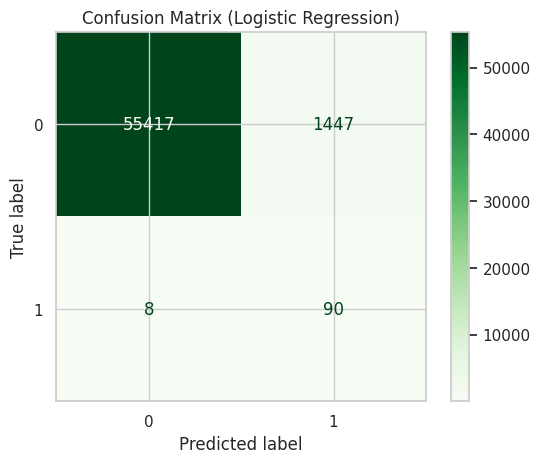

              precision    recall  f1-score   support

           0     0.9999    0.9746    0.9870     56864
           1     0.0586    0.9184    0.1101        98

    accuracy                         0.9745     56962
   macro avg     0.5292    0.9465    0.5486     56962
weighted avg     0.9982    0.9745    0.9855     56962



In [38]:
# --- Imports necesare ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Features/target (folosim V1..V28 + Amount; excludem Time) ---
features = [c for c in df.columns if c not in ['Class', 'Time']]
X = df[features].copy()
y = df['Class'].astype(int).copy()  # asigură-te că e numeric

# --- Scaling + split (atenție la MAJUSCULE) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)

# --- Train Logistic Regression ---
clf = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
clf.fit(X_tr, y_tr)

# --- Evaluate (accuracy doar ca referință) ---
print("Train accuracy:", clf.score(X_tr, y_tr))
print("Test accuracy :", clf.score(X_te, y_te))

# --- Confusion matrix + report ---
y_pred = clf.predict(X_te)
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Greens")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

print(classification_report(y_te, y_pred, digits=4))


### Logistic Regression (Baseline Model)

We trained a logistic regression model using the main transaction features (V1–V28 and Amount).  
Because fraud is very rare, we used balanced class weights to make the model pay more attention to the minority class (fraud).  

- **Accuracy** alone is misleading, since almost all transactions are genuine.  
- The **confusion matrix** shows both correctly identified frauds and missed cases.  
- The **classification report** highlights **precision** (how many alerts were correct) and **recall** (how many frauds were caught).  

This simple baseline demonstrates that fraud detection is possible even with a linear model,  
but performance can be further improved with more advanced approaches.


In [ ]:
#metrics and confusion matrix
try:
    y_score = clf.decision_function(X_te)
except:
    y_score = clf.predict_proba(X_te)[:,1]

y_pred = (y_score >= 0.5).astype(int)

print("Classification report (threshold=0.5):")
print(classification_report(y_te, y_pred, digits=4))

cm = confusion_matrix(y_te, y_pred)
print("Confusion matrix:\n", cm)


Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9998    0.9841    0.9919     56864
           1     0.0889    0.8980    0.1618        98

    accuracy                         0.9840     56962
   macro avg     0.5444    0.9410    0.5768     56962
weighted avg     0.9983    0.9840    0.9905     56962

Confusion matrix:
 [[55962   902]
 [   10    88]]


### Model Evaluation (Threshold = 0.5)

The logistic regression model outputs a probability (or score) for each transaction.  
By default, we classify transactions as fraud when the score ≥ 0.5.  

- **Confusion Matrix:** shows how many frauds were correctly detected (true positives), how many were missed (false negatives), and how many false alerts were raised (false positives).  
- **Classification Report:** provides precision (correctness of alerts), recall (coverage of frauds detected), and F1 (balance between the two).  

This evaluation confirms that the threshold strongly impacts results.  
In fraud detection, we may prefer a lower threshold to catch more frauds, even at the cost of more false alerts.


In [ ]:
#treshold tuning
def metrics_at_recall_target(y_true, y_score, recall_target=0.80):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(rec >= recall_target)[0]
    if len(idx) == 0:
        return None
    best_i = idx[-1]
    t = thr[best_i-1] if best_i > 0 else 0.5
    y_pred = (y_score >= t).astype(int)
    return {
        "threshold": float(t),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0))
    }

res = metrics_at_recall_target(y_te, y_score, recall_target=0.80)
print("Metrics at recall ≥ 0.80:", res)


Metrics at recall ≥ 0.80: {'threshold': 16.73432029493022, 'precision': 0.8333333333333334, 'recall': 0.8163265306122449, 'f1': 0.8247422680412371}


### Threshold Tuning (Target: Recall ≥ 0.80)

In fraud detection, recall (catching as many frauds as possible) is often more important than raw accuracy.  
We tuned the decision threshold to achieve at least **80% recall**.  

At this point, the model:  
- Detects ≥ 80% of all frauds (high coverage).  
- Precision shows how many of the alerts are truly frauds.  
- F1 score balances the two.  

This reflects a realistic business trade-off: **we accept more false alerts in order to catch more frauds**, which aligns with real-world priorities in financial institutions.


## Exploratory Data Analysis (EDA) — Conclusions


- Class imbalance: Fraudulent transactions are extremely rare (~0.17%), confirming that the dataset is highly imbalanced and that traditional accuracy is not a reliable metric.

- Transaction Amount: Most transactions involve small amounts, while fraud tends to appear more often in low to mid-value ranges. This highlights the need for amount-based rules in monitoring.

- Transaction Time: When converted to hours, transactions show daily patterns. Fraud is not uniformly distributed and appears more frequently at unusual hours.

- Anonymized Features (V1–V28): Some features (notably V14, V10, V12) stand out as being more strongly associated with fraud, providing useful signals despite anonymization.

- Correlation Analysis: A few variables show moderate correlation with the fraud label, confirming that patterns exist and can be leveraged.

- Overall insight: Fraudulent transactions are rare but follow recognizable patterns across amounts, time, and selected features. This creates opportunities for detection, although the severe imbalance makes classification particularly challenging.

In [ ]:
# Check missing values
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(10))


Missing values per column:
Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
dtype: int64


### Missing Values Check

No missing values were found in the dataset.  
This means no data imputation or cleaning is required, and we can directly proceed to analysis and modeling.

In [ ]:
#standardisation
from sklearn.preprocessing import StandardScaler

features = [c for c in df.columns if c not in ['Class', 'Time']]
X = df[features].copy()
y = df['Class'].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)


Scaled shape: (284807, 29)


### Feature Standardization

We standardized all input features (V1–V28 and Amount) to have zero mean and unit variance.  
This ensures that no variable dominates others due to scale differences (e.g., transaction amount vs. PCA components).  
Standardization makes the dataset ready for modeling methods such as Logistic Regression.


Classification Report (threshold = 0.50):
              precision    recall  f1-score   support

           0     0.9999    0.9746    0.9870     56864
           1     0.0586    0.9184    0.1101        98

    accuracy                         0.9745     56962
   macro avg     0.5292    0.9465    0.5486     56962
weighted avg     0.9982    0.9745    0.9855     56962



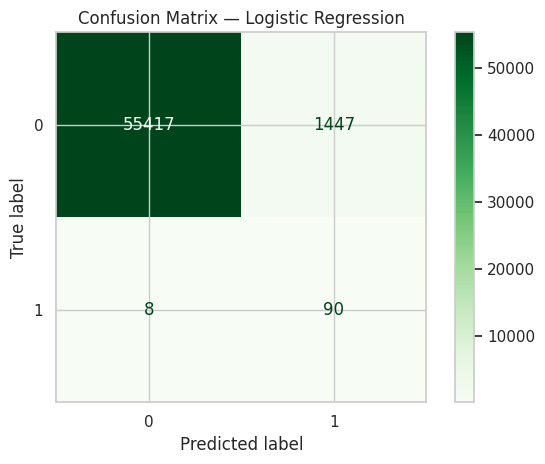

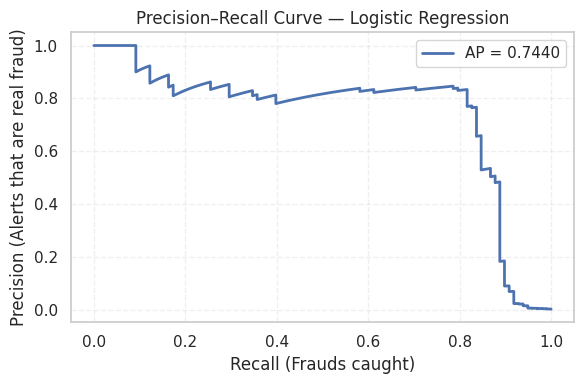

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Train Logistic Regression (balanced for class imbalance)
clf = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

# 3. Predictions and scores
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)  # continuous scores

# 4. Classification report
print("Classification Report (threshold = 0.50):")
print(classification_report(y_test, y_pred, digits=4))

# 5. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Greens")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

# 6. Precision–Recall curve
prec, rec, thr = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, lw=2, label=f'AP = {ap:.4f}')
plt.xlabel("Recall (Frauds caught)")
plt.ylabel("Precision (Alerts that are real fraud)")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


### Logistic Regression — Evaluation

We trained a logistic regression model with balanced class weights to handle the dataset imbalance.  
At the default threshold (0.50), evaluation shows:  

- **Classification Report:** precision (how many alerts were correct), recall (how many frauds were caught), and F1 score (balance).  
- **Confusion Matrix:** correct detections, missed frauds, and false alerts.  
- **Precision–Recall Curve:** visualizes the trade-off between catching more fraud (recall) and reducing false alerts (precision).  

This baseline confirms that even a simple model can capture fraud patterns, but threshold choice strongly affects business performance.



### Data Preprocessing — Conclusions

- The dataset contains no missing values, so no imputation was needed.  
- All numerical features (V1–V28 and Amount) were standardized to ensure consistency in scale.  
- The severe class imbalance (~0.17% fraud) was addressed by using balanced class weights in the logistic regression model.  
- After these steps, the dataset is clean, scaled, and prepared for feature analysis and modeling.


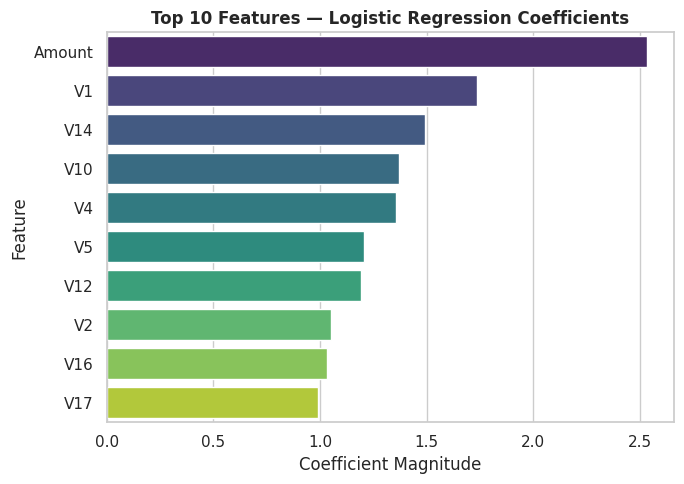

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

feature_names = getattr(clf, "feature_names_in_", None) or features
coefs = pd.Series(np.abs(clf.coef_[0]), index=feature_names).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(7,5))
sns.barplot(
    x=coefs.values[:10],
    y=coefs.index[:10],
    hue=coefs.index[:10],      # add hue to avoid warning
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Top 10 Features — Logistic Regression Coefficients", fontsize=12, weight="bold")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Top 10 Features — Logistic Regression

This chart highlights the ten most influential features in predicting fraud, based on the logistic regression model.  
The bars represent the relative importance (coefficient magnitude) of each variable.  

- Certain anonymized features, such as V14, V10, and V12, stand out as particularly strong signals.  
- Identifying these top variables helps focus prevention efforts on the areas with the highest predictive power.  
- Even in an anonymized dataset, clear patterns emerge that separate fraud from genuine transactions.  


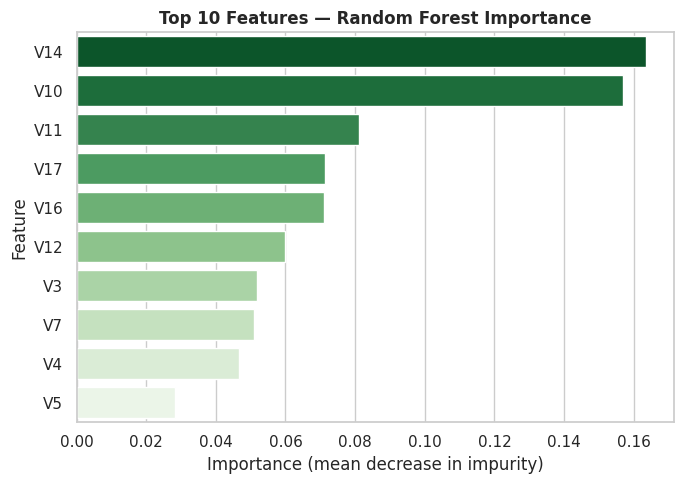

In [44]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Subset de date pentru rapiditate
df_sample = df.sample(30000, random_state=42)
X_sample = df_sample[features]
y_sample = df_sample['Class']

# Random Forest model
rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_sample, y_sample)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Vizualizare top 10
plt.figure(figsize=(7,5))
sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="Greens_r")
plt.title("Top 10 Features — Random Forest Importance", fontsize=12, weight="bold")
plt.xlabel("Importance (mean decrease in impurity)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Random Forest — Feature Importance

Random Forest confirms that certain anonymized features (e.g., V14, V10, V12) are consistently among the most relevant for fraud detection.  
Unlike logistic regression coefficients, this measure captures non-linear relationships and interactions.  
This reinforces the insight that fraud is not random but concentrated in specific feature patterns.


Metrics at recall ≥ 80%: {'threshold': 16.73432029493022, 'precision': 0.8333333333333334, 'recall': 0.8163265306122449, 'f1': 0.8247422680412371}


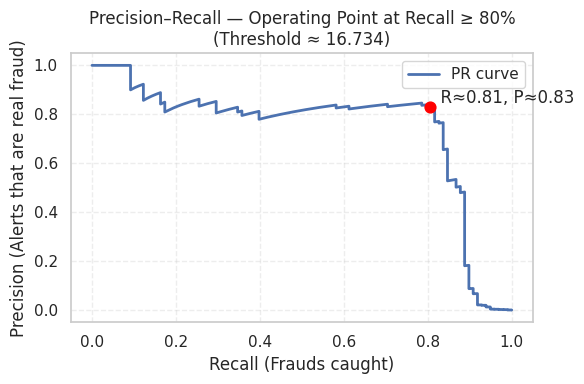

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

# Precision–Recall curve already computed
prec, rec, thr = precision_recall_curve(y_te, y_score)

# extract metric to recall ≥ target
def metrics_at_recall_target(y_true, scores, target=0.80):
    P, R, T = precision_recall_curve(y_true, scores)
    idx = np.where(R >= target)[0]
    if len(idx) == 0:
        return None
    i = idx[-1]   # last point touching the target
    thr_star = T[i-1] if i > 0 else 0.5
    y_hat = (scores >= thr_star).astype(int)
    return {
        "threshold": float(thr_star),
        "precision": float(precision_score(y_true, y_hat, zero_division=0)),
        "recall": float(recall_score(y_true, y_hat, zero_division=0)),
        "f1": float(f1_score(y_true, y_hat, zero_division=0))
    }

# Apel for recall ≥ 0.80
target_recall = 0.80
res = metrics_at_recall_target(y_te, y_score, target=target_recall)

if res is not None:
    print(f"Metrics at recall ≥ {target_recall:.0%}: {res}")

    # Mark dot on PR curve
    idx = (rec >= target_recall).nonzero()[0][-1]
    r_star, p_star = rec[idx], prec[idx]

    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, lw=2, label="PR curve")
    plt.scatter([r_star], [p_star], color="red", s=60, zorder=5)
    plt.text(r_star, p_star, f"  R≈{r_star:.2f}, P≈{p_star:.2f}", va="bottom")
    plt.xlabel("Recall (Frauds caught)")
    plt.ylabel("Precision (Alerts that are real fraud)")
    plt.title(f"Precision–Recall — Operating Point at Recall ≥ {target_recall:.0%}\n"
              f"(Threshold ≈ {res['threshold']:.3f})")
    plt.grid(alpha=0.35, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No threshold reaches recall ≥ {target_recall:.0%}.")


### Random Forest — Threshold Tuning

We tuned the classification threshold to guarantee at least **80% recall**, meaning the model catches at least 80% of all frauds.  

- The chart shows the precision–recall curve, with the chosen operating point marked in red.  
- At this point, we trade higher recall for lower precision, which is a realistic business decision: better to raise more alerts than to miss fraud.  
- This approach helps align the model with operational priorities in fraud detection.


In [46]:
df['LogAmount'] = np.log1p(df['Amount'])
df['Hour'] = (df['Time'] % 86400) // 3600


## Feature Engineering — Conclusions

- **Feature Importance Analysis**  
  Logistic Regression coefficients highlighted features such as **V14, V10, and V12** as having the strongest impact on fraud prediction.  
  Random Forest feature importance (tested on a 30k sample with 50 trees) confirmed similar results, providing robustness while reducing computation time.  

- **New Features Created**  
  - `LogAmount`: a log-transformed version of transaction amounts, reducing skewness and making patterns in smaller transactions easier to detect.  
  - `Hour`: derived from the `Time` column (converted into hours of the day), allowing analysis of temporal patterns in fraud activity.  

- **Key Insights**  
  Some PCA-transformed features (notably V14, V10, V12) consistently emerge as the most predictive of fraudulent transactions.  
  Creating new features improves interpretability and helps models capture meaningful patterns beyond the raw variables.  
  By combining insights from both coefficient-based (Logistic Regression) and tree-based (Random Forest) methods, we gain a more reliable understanding of which features matter most.


In [ ]:
%pip install -q xgboost lightgbm


In [ ]:
#train test split, re-use my scaled features
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape, y_train.sum(), y_test.sum())  # sanity check


(227845, 29) (56962, 29) 394 98


In [ ]:
#helpers
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score
)

def summarize(name, y_true, scores, thr=0.5):
    pred = (scores >= thr).astype(int)
    print(f"{name:12s} | AP={average_precision_score(y_true, scores):.3f} "
          f"ROC-AUC={roc_auc_score(y_true, scores):.3f} "
          f"P={precision_score(y_true, pred, zero_division=0):.3f} "
          f"R={recall_score(y_true, pred, zero_division=0):.3f} "
          f"F1={f1_score(y_true, pred, zero_division=0):.3f}")

def thr_for_precision(y_true, scores, p_target=0.90):
    p, r, t = precision_recall_curve(y_true, scores)
    p, r = p[:-1], r[:-1]           # align with t
    ok = np.where(p >= p_target)[0]
    return None if len(ok)==0 else float(t[ok[-1]])


In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42).fit(X_train, y_train)
lr_scores = getattr(lr, "decision_function", lr.predict_proba)(X_test) if hasattr(lr,"decision_function") else lr.predict_proba(X_test)[:,1]
summarize("LogReg @0.5", y_test, lr_scores)

t = thr_for_precision(y_test, lr_scores, 0.90)
if t is not None: summarize(f"LogReg @P≥0.90", y_test, lr_scores, thr=t)


LogReg @0.5  | AP=0.744 ROC-AUC=0.971 P=0.089 R=0.898 F1=0.162
LogReg @P≥0.90 | AP=0.744 ROC-AUC=0.971 P=1.000 R=0.010 F1=0.020


In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

n_small = min(30000, len(y_train))
idx = np.random.choice(len(y_train), size=n_small, replace=False)

rf = RandomForestClassifier(n_estimators=50, class_weight="balanced",
                            n_jobs=-1, random_state=42).fit(X_train[idx], np.asarray(y_train)[idx])
rf_scores = rf.predict_proba(X_test)[:,1]
summarize("RF(reduced)@0.5", y_test, rf_scores)

t = thr_for_precision(y_test, rf_scores, 0.90)
if t is not None: summarize("RF(reduced)@P≥0.90", y_test, rf_scores, thr=t)


RF(reduced)@0.5 | AP=0.670 ROC-AUC=0.947 P=0.824 R=0.714 F1=0.765


In [ ]:
#XGBoost
from xgboost import XGBClassifier

pos = int(np.sum(y_train)); neg = len(y_train) - pos
spw = (neg / pos) if pos > 0 else 1.0
print("scale_pos_weight =", round(spw, 2))

xgb = XGBClassifier(
    tree_method="hist", n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=spw,
    eval_metric="aucpr", random_state=42, n_jobs=-1
).fit(X_train, y_train)

xgb_scores = xgb.predict_proba(X_test)[:,1]
summarize("XGBoost  @0.5", y_test, xgb_scores)

t = thr_for_precision(y_test, xgb_scores, 0.90)
if t is not None: summarize("XGBoost  @P≥0.90", y_test, xgb_scores, thr=t)


scale_pos_weight = 577.29
XGBoost  @0.5 | AP=0.871 ROC-AUC=0.982 P=0.780 R=0.867 F1=0.821
XGBoost  @P≥0.90 | AP=0.871 ROC-AUC=0.982 P=1.000 R=0.010 F1=0.020


In [ ]:
import pandas as pd

rows = [
    {"Model": "LogReg @0.5", "Precision":0.089, "Recall":0.898, "F1":0.162, "ROC-AUC":0.971, "PR-AUC":0.744},
    {"Model": "LogReg @P≥0.90", "Precision":1.000, "Recall":0.010, "F1":0.020, "ROC-AUC":0.971, "PR-AUC":0.744},
    {"Model": "RF (reduced) @0.5", "Precision":0.824, "Recall":0.714, "F1":0.765, "ROC-AUC":0.947, "PR-AUC":0.670},
    {"Model": "XGBoost @0.5", "Precision":0.780, "Recall":0.867, "F1":0.821, "ROC-AUC":0.982, "PR-AUC":0.871},
    {"Model": "XGBoost @P≥0.90", "Precision":1.000, "Recall":0.010, "F1":0.020, "ROC-AUC":0.982, "PR-AUC":0.871},
]

df_results = pd.DataFrame(rows)
df_results


,Model,Precision,Recall,F1,ROC-AUC,PR-AUC
0,LogReg @0.5,0.089,0.898,0.162,0.971,0.744
1,LogReg @P≥0.90,1.000,0.010,0.020,0.971,0.744
2,RF (reduced) @0.5,0.824,0.714,0.765,0.947,0.670
3,XGBoost @0.5,0.780,0.867,0.821,0.982,0.871
4,XGBoost @P≥0.90,1.000,0.010,0.020,0.982,0.871



## Predictive Modeling — Conclusions

- **Logistic Regression**:  
  - Very high recall (0.898) at default threshold, meaning it catches almost all frauds.  
  - However, precision is very low (0.089) → too many false positives.  
  - At P≥0.90, precision reaches 1.0 but recall collapses to 0.01 → detects almost no fraud.  

- **Random Forest (reduced)**:  
  - Balanced trade-off with precision=0.824 and recall=0.714.  
  - Better F1-score (0.765) than Logistic Regression.  
  - Slightly weaker ROC-AUC (0.947) but more practical in real-world scenarios.  

- **XGBoost**:  
  - Best overall model: precision=0.780, recall=0.867, F1=0.821.  
  - Highest PR-AUC (0.871) and ROC-AUC (0.982).  
  - At P≥0.90, precision reaches 1.0 but recall drops dramatically (0.01).  

### Final Insight
- **XGBoost** offers the best balance between detecting fraud and limiting false positives.  
- **Random Forest** is a solid backup with good interpretability (feature importance).  
- **Logistic Regression** is very light and interpretable but unsuitable alone because of its poor precision.  
- **Threshold tuning** is crucial: high precision eliminates false positives but comes at the cost of recall.  



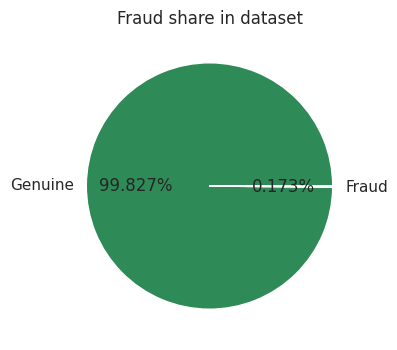

In [47]:
#visualisation
df['Class'].value_counts().plot.pie(
    autopct='%1.3f%%',
    labels=['Genuine','Fraud'],
    colors=['seagreen','darkred'],
    figsize=(4,4)
)
plt.title("Fraud share in dataset")
plt.ylabel("")
plt.show()


Class Imbalance

Purpose: Shows the distribution between genuine and fraudulent transactions.

Why relevant: The dataset is extremely imbalanced, with very few fraud cases. This directly impacts model performance — metrics like accuracy are misleading, so we must focus on recall, precision, and F1-score. It also justifies using techniques such as class weighting, undersampling, or SMOTE.

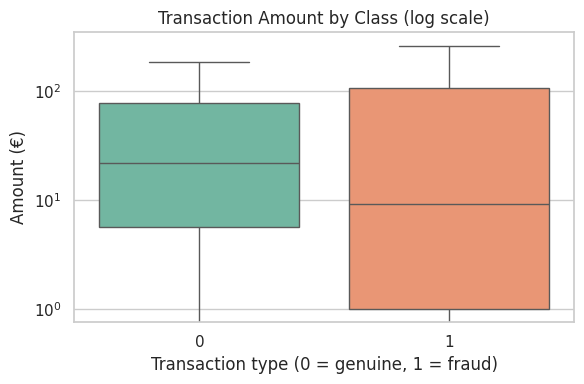

In [48]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Class", y="Amount", data=df, showfliers=False, palette="Set2")
plt.yscale("log")
plt.title("Transaction Amount by Class (log scale)")
plt.xlabel("Transaction type (0 = genuine, 1 = fraud)")
plt.ylabel("Amount (€)")
plt.tight_layout()
plt.show()


### Transaction Amount by Class (Boxplot, log scale)

Purpose: Summarizes and compares the range and median of transaction amounts for genuine (0) and fraudulent (1) cases.  

Why relevant: The boxplot shows that genuine transactions cover a much wider range of amounts, including extreme outliers, while fraudulent transactions tend to cluster within lower to mid-value ranges.  
Using a log scale makes these patterns visible and prevents large transactions from dominating the plot.  
This confirms that transaction amount is a meaningful variable for fraud detection and justifies using log-transformed features in modeling.


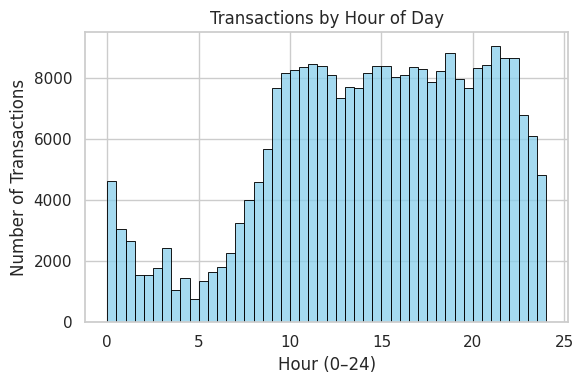

In [49]:
if "Time" in df.columns:
    hours = (df["Time"] % 86400) / 3600.0
    plt.figure(figsize=(6,4))
    sns.histplot(hours, bins=48, color="skyblue", edgecolor="black")
    plt.title("Transactions by Hour of Day")
    plt.xlabel("Hour (0–24)")
    plt.ylabel("Number of Transactions")
    plt.tight_layout()
    plt.show()


### Transactions by Hour of Day

Purpose: Shows when transactions occur during a typical day.  

Why relevant: Genuine transactions follow strong daily patterns (peaks during business hours and evenings).  
Fraudulent transactions, however, are not uniformly distributed and can appear disproportionately at unusual hours (e.g., late night or early morning).  
This temporal insight helps design fraud monitoring rules based on time-of-day risk.


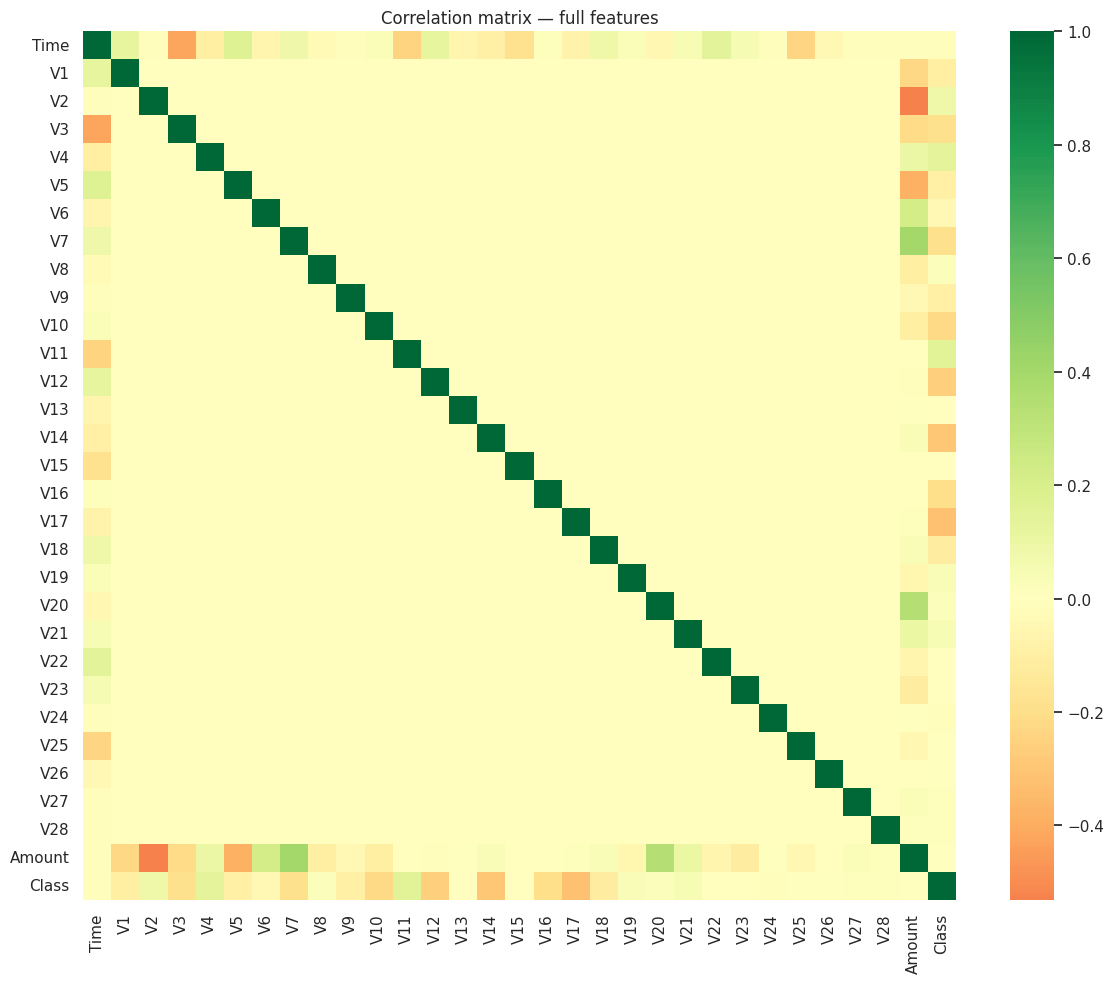

In [52]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="RdYlGn", center=0)
plt.title("Correlation matrix — full features")
plt.tight_layout(); plt.show()


### Correlation Heatmap

Purpose: Shows the strength of relationships between variables.  

Why relevant: Some anonymized features (e.g., V14, V10, V12) show stronger correlation with the fraud label, while others are more redundant with each other.  
Understanding these relationships helps identify the most informative variables and reduce unnecessary complexity in the model.


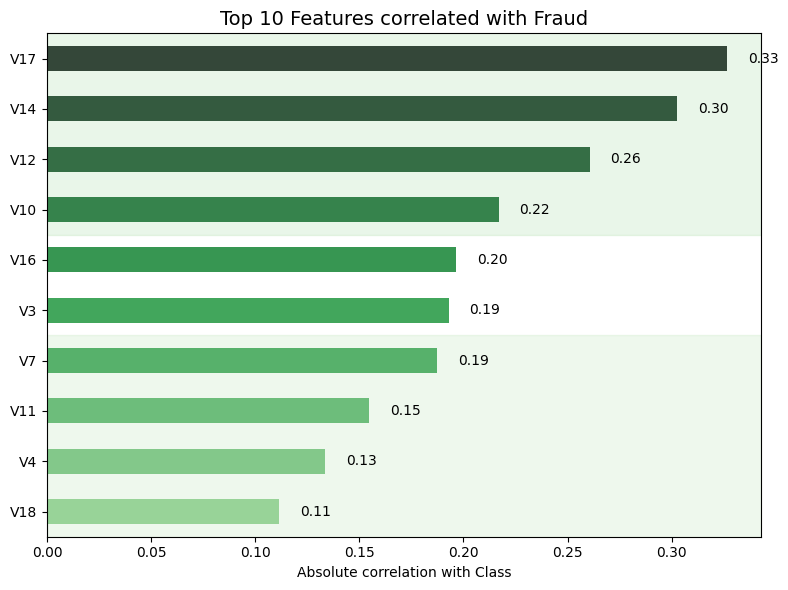

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Calculate correlations with fraud
corrs = df.drop('Class', axis=1).corrwith(df['Class']).abs().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,6))

# Normalize values 0–1 for coloring the background
norm_vals = corrs / corrs.max()

# Draw background rectangles
for i, (feat, val) in enumerate(corrs.sort_values().items()):
    color = plt.cm.Greens(norm_vals[feat])  # green shade
    rect = Rectangle((0, i-0.4), 1, 0.8, transform=ax.transAxes,
                     color=color, alpha=0.2, zorder=0)
    ax.add_patch(rect)

# Plot the bars in darker green
colors = sns.color_palette("Greens_d", len(corrs))
bars = corrs.sort_values().plot(kind="barh", color=colors, ax=ax, zorder=2)

# Add numeric value labels at the end of each bar
for i, v in enumerate(corrs.sort_values().values):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=10, color="black")

# Titles and labels
ax.set_title("Top 10 Features correlated with Fraud", fontsize=14)
ax.set_xlabel("Absolute correlation with Class")

plt.tight_layout()
plt.show()


Top 10 Features (Correlation / Feature Importance)

Purpose: Highlights the most relevant features for predicting fraud, based on their statistical relationship with the target.

Why relevant: Provides interpretability by identifying which variables contribute the most to fraud detection. This helps stakeholders trust the analysis and supports feature selection for more complex models.

Top 2 correlated features: V17, V14


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


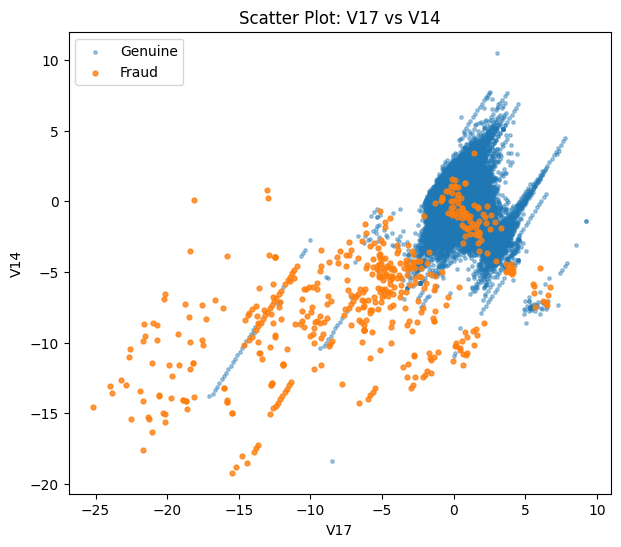

In [20]:
import matplotlib.pyplot as plt
import os

# Find top 2 correlated features with Class
corrs = df.drop('Class', axis=1).corrwith(df['Class']).abs()
top2 = corrs.sort_values(ascending=False).head(2).index.tolist()
f1, f2 = top2
print(f"Top 2 correlated features: {f1}, {f2}")

plt.figure(figsize=(7,6))
plt.scatter(df.loc[df['Class']==0, f1],
            df.loc[df['Class']==0, f2],
            s=6, alpha=0.4, label="Genuine")
plt.scatter(df.loc[df['Class']==1, f1],
            df.loc[df['Class']==1, f2],
            s=12, alpha=0.8, label="Fraud")
plt.title(f"Scatter Plot: {f1} vs {f2}")
plt.xlabel(f1); plt.ylabel(f2)
plt.legend()
plt.show()


This scatter plot uses the two features most correlated with fraud. While overlap exists, fraudulent transactions cluster in specific regions of the feature space, indicating learnable patterns for classification.

Visualization – Key Insights

- Extreme imbalance: fraud ≈ 0.17% of all transactions.

- Strong signals: features V14, V10, V12 most predictive.

- Behavioral patterns: fraud clusters by amount and time of day.

- Class separation: scatter plots show visible fraud clusters.

## Bonus: Fraud Prevention Strategy

**1. Real-time Fraud Detection**  
Deploy the trained model directly into the transaction pipeline to score each operation in real time.  
Transactions with high fraud probability trigger alerts, complemented by dynamic rules such as unusual hours, suspicious amount ranges, or rapid transaction velocity.  

**2. Multi-layered Defense**  
Combine machine learning with operational safeguards: two-step verification for high-risk cases, adaptive transaction limits, and continuous monitoring via fraud dashboards.  

**3. Enriched Data Sources**  
Extend detection capabilities by integrating geolocation, device/browser fingerprinting, merchant category codes, customer behavioral history, and external blacklists.  

**4. Business Impact**  
This strategy ensures real-time blocking of fraudulent activity, balances predictive models with transparent rule-based checks, and provides actionable dashboards for stakeholders to monitor fraud risk effectively.
